# Import data.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from bayesianLearner import *
from matplotlib.patches import FancyBboxPatch

### Import dataset.

In [2]:
colors = ['#1f77b4', '#ff7f0e']

In [4]:
dname = '/media/jacques/DATA1/2019_MusicPred/experimentContinuousMatrix/data/behavior/'
dname = '/home/jacques/Documents/2019_MusicPred/experimentContinuousMatrix/data/behavior/'
# Experimental
MUSICIANS = np.load(dname + 'MUSICIANS.npy')
CHOICES = np.load(dname + 'CHOICES.npy')
DEC = np.load(dname + 'DEC.npy')
SEQS = np.load(dname + 'SEQS.npy')
PERF = np.load(dname + 'PERF.npy')
RT = np.load(dname + 'RT.npy')
SEQ_ID = np.load(dname + 'SEQ_ID.npy')
sujs = np.load(dname + 'sujs.npy', allow_pickle=True)

# Training
CHOICES_TRAINING = np.load(dname + 'CHOICES_TRAINING.npy')
SEQS_TRAINING = np.load(dname + 'SEQS_TRAINING.npy')
PERF_TRAINING = np.load(dname + 'PERF_TRAINING.npy')
RT_TRAINING = np.load(dname + 'RT_TRAINING.npy')

SEQS.shape

(53, 10, 300)

In [5]:
n_sujs, n_seqs, n_tones = SEQS.shape
n_dec = RT.shape[-1]
N_VOC = np.unique(SEQS[np.logical_not(np.isnan(SEQS))]).size

### Make model predictions.

In [6]:
n_hierarchy = 3
hierachies = np.arange(n_hierarchy)

In [ ]:
PERF_MODEL = np.full((n_hierarchy, n_seqs, n_dec), np.nan)
CHOICES_MODEL = np.full((n_hierarchy, n_seqs, n_tones), np.nan)

In [ ]:
suj = -1 # all sujs have the same sequence
for i, i_seq in enumerate(range(n_seqs)):

    # Retrieve sequence
    seq = np.array(SEQS[suj, SEQ_ID[suj] == i_seq], dtype=np.int)[0]
    _seq = np.zeros((n_tones, N_VOC))
    _seq[np.arange(n_tones), seq] = 1
    
    for k, K in enumerate(hierachies):
        _, _, CHOICES_MODEL[k, i], _, _ = bayesianHierarchicalInverter(_seq.copy(),
              K=K, noise_sensory=None, noise_inference=None, noise_decision=None)
        idx_pred = np.array(DEC[suj, SEQ_ID[suj] == i_seq], dtype=np.bool)[0]
        PERF_MODEL[k, i] = seq[idx_pred] == CHOICES_MODEL[k, i, idx_pred]

### Model fitting.

In [13]:
hierachies = np.arange(n_hierarchy)
inference_noises = np.logspace(*np.log10([2, 100]), num=200, base=10)
decision_noises = np.logspace(*np.log10([1e-1, 2]), num=200, base=10)

In [ ]:
# Compute posterior predictive for all models
POSTERIOR = np.zeros((hierachies.size, inference_noises.size, decision_noises.size, n_seqs, n_tones, N_VOC))
suj = -1 # all sujs have the same sequence

for i, i_seq in enumerate(range(n_seqs)):
        
    # Retrieve sequence
    seq = np.array(SEQS[suj, SEQ_ID[suj] == i_seq], dtype=np.int)[0]
    _seq = np.zeros((n_tones, N_VOC))
    _seq[np.arange(n_tones), seq] = 1
    
    # Compute posterior for all models
    for j, K in enumerate(hierachies):
        for k, tau in enumerate(inference_noises): 
            for l, beta in enumerate(decision_noises):
                POSTERIOR[j, k, l, i], _, _, _, _ = bayesianHierarchicalInverter(_seq.copy(),
                         K=K, noise_sensory=noise_sensory, noise_inference=tau, noise_decision=beta)

In [ ]:
# Compute likelihood of participants responses for all models
LIKELIHOOD = np.zeros((n_sujs, hierachies.size, inference_noises.size, decision_noises.size))
P = np.zeros((n_sujs, n_seqs, hierachies.size, inference_noises.size, decision_noises.size)) # Not very usefull

for j, K in enumerate(hierachies):
    for k, tau in enumerate(inference_noises): 
        for l, beta in enumerate(decision_noises):
            for m, i_seq in enumerate(range(n_seqs)):
                for s, suj in enumerate(sujs):
                
                    # Subject choices
                    _choices = CHOICES[s, SEQ_ID[s] == i_seq]
                    _choices[np.isnan(_choices)] = 0
                    choices = np.array(_choices, dtype=np.int)
                    if choices.size == 0: continue

                    # Decision loci
                    idx = DEC[s, SEQ_ID[s] == i_seq][0]
                    idx = np.array(idx, dtype=np.bool)

                    # Carefull : we only sample a few choices, not all !
                    p = POSTERIOR[j, k, l, m][idx, choices]
                    p[np.isnan(_choices)] = np.nan
                    P[s, m, j, k, l] = np.nanmean(p)
                    ll = np.log(p)
                    LIKELIHOOD[s, j, k, l] += np.nansum(ll)

In [ ]:
np.save(dname + 'LIKELIHOOD', LIKELIHOOD)
np.save(dname + 'P', P)

### Fig. Supp. 1

In [8]:
LIKELIHOOD = np.load(dname + 'LIKELIHOOD.npy')
P = np.load(dname + 'P.npy')

In [9]:
def jitter(x):
    return np.random.normal(0, x)

In [15]:
# Filter bad sujs
idx = sujs != 5

In [41]:
PERF_MEAN = np.nanmean(PERF, axis=(1, 2))
PERF_MEAN[np.logical_not(idx)] = np.nan

<ipython-input-47-7602c938f221>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(decision_noises, inference_noises, L[i], alpha=1, vmin=vmin, vmax=vmax)
<ipython-input-47-7602c938f221>:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  color=colors[MUSICIANS[s, 0, 0]], label='MLE suj_' + str(suj), s=size,


10
True
39
False


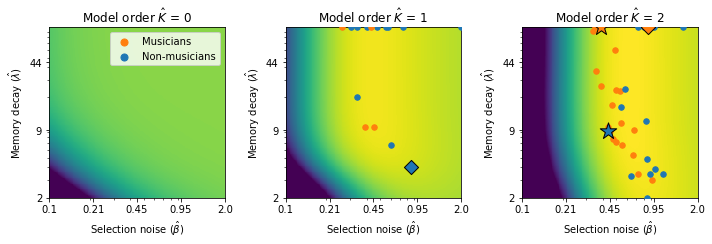

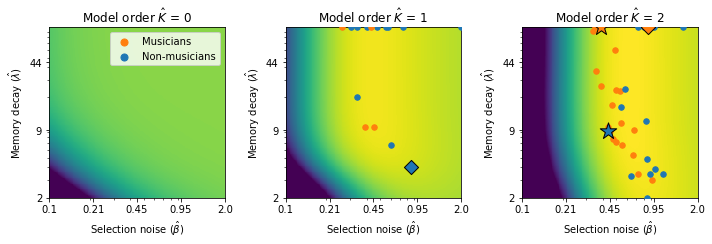

In [47]:
fig, axs = plt.subplots(1, hierachies.size, figsize=(10, 3.5), facecolor='w')

L = np.nansum(LIKELIHOOD, axis=0) # Summed likelihood
vmin = L.min()/2.
vmax = L.max()

for i, (ax, hierarchy) in enumerate(zip(axs, hierachies)):
    ax.pcolor(decision_noises, inference_noises, L[i], alpha=1, vmin=vmin, vmax=vmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Selection noise ($\hat{\beta}$)')
    ax.set_ylabel(r'Memory decay ($\hat{\lambda}$)')
    ax.set_xticks(np.logspace(*np.log10([1e-1, 2]), num=5, base=10))
    ax.set_yticks(np.logspace(*np.log10([2, 1000]), num=5, base=10))
    ax.set_xticklabels(np.around(np.logspace(*np.log10([1e-1, 2]), num=5, base=10), 2))
    ax.set_yticklabels(np.array(np.logspace(*np.log10([2, 1000]), num=5, base=10), np.int))
    ax.set_xlim(decision_noises.min(), decision_noises.max())
    ax.set_ylim(inference_noises.min(), inference_noises.max())
    ax.set_title('Model order $\hat{K}$ = ' + str(hierarchy))

# Maximum estimates
for s, suj in enumerate(sujs):
    if suj == 5: continue
    a, b, c = np.unravel_index(np.argmax(LIKELIHOOD[s], axis=None), LIKELIHOOD[s].shape)
    if PERF_MEAN[s] == np.nanmin(PERF_MEAN[MUSICIANS[:, 0, 0] == MUSICIANS[s, 0, 0]]) and s != 49:
        marker = 'D'; size = 100; edgecolors = 'k'; zorder=100
    elif PERF_MEAN[s] == np.nanmax(PERF_MEAN[MUSICIANS[:, 0, 0] == MUSICIANS[s, 0, 0]]):
        marker = '*'; size = 300; edgecolors = 'k'; zorder=100
    else:
        marker = 'o'; size = 30; edgecolors = None; zorder=20
    if inference_noises[b] == np.max(inference_noises): 
        y = inference_noises[b] * 0.95 # Adjust to plot extreme values
    else:
        y = inference_noises[b]
    axs[a].scatter(decision_noises[c], inference_noises[b], marker=marker, 
                   color=colors[MUSICIANS[s, 0, 0]], label='MLE suj_' + str(suj), s=size,
                   edgecolors=edgecolors, zorder=zorder)

# Add legend
for musi in ([True, False]):
    label = 'Musicians' if musi == True else 'Non-musicians'
    axs[0].scatter(-10, -10, color=colors[musi], label=label, s=50)
axs[0].legend(loc=1)

plt.tight_layout()
fig

In [ ]:
fname = '/media/jacques/DATA1/2019_MusicPred/experimentContinuousMatrix/analysis/Figures/Figure_Supp_1.png'
fig.savefig(fname, bbox_inches='tight')

### Save model surprise for EEG analysis.

In [ ]:
SURPRISE_FITTED = np.full(SEQS.shape, np.nan)
PREDICTED_SOUND_FITTED = np.full(SEQS.shape, np.nan)

In [ ]:
for i, suj in enumerate(sujs):
    
    # Retrieve parameters for this subject
    a, b, c = np.unravel_index(np.argmax(LIKELIHOOD[s], axis=None), LIKELIHOOD[s].shape)
    k = hierachies[a]
    inference_noise = inference_noises[b]
    decision_noise = decision_noises[c]
    
    for j, j_seq in enumerate(range(n_seqs)):

        # Don't do it if _seq contains nans
        if np.any(np.isnan(SEQS[i, j])):
            continue

        # Retrieve sequence
        seq = np.array(SEQS[i, j], dtype=np.int)
        _seq = np.zeros((n_tones, N_VOC))
        _seq[np.arange(n_tones), seq] = 1        

        # Compute model posterior
        _P, _, _, _, _ = bayesianHierarchicalInverter(_seq.copy(),
                 K=k, noise_sensory=noise_sensory, noise_inference=inference_noise, noise_decision=decision_noise)
        
        # Save model surprise
        SURPRISE_FITTED[i, j] = - np.log(_P[np.arange(n_tones), seq])
        PREDICTED_SOUND_FITTED[i, j] = np.argmax(_P, axis=-1)

np.save(dname + 'SURPRISE_FITTED', SURPRISE_FITTED)
np.save(dname + 'PREDICTED_SOUND_FITTED', PREDICTED_SOUND_FITTED)

In [ ]:
SURPRISE_FITTED = np.load(dname + 'SURPRISE_FITTED.npy')
PREDICTED_SOUND_FITTED = np.load(dname + 'PREDICTED_SOUND_FITTED.npy')

In [ ]:
SURPRISE = np.full((3, n_sujs, n_seqs, n_tones), np.nan)

In [ ]:
for i, suj in enumerate(sujs):
    
    for j, j_seq in enumerate(range(n_seqs)):

        # Don't do it if _seq contains nans
        if np.any(np.isnan(SEQS[i, j])):
            continue

        # Retrieve sequence
        seq = np.array(SEQS[i, j], dtype=np.int)
        _seq = np.zeros((n_tones, N_VOC))
        _seq[np.arange(n_tones), seq] = 1        
        
        # For each level of hierarchy K
        for k in range(3):

            # Retrieve parameters for this subject and this K
            b, c = np.unravel_index(np.argmax(LIKELIHOOD[i, k], axis=None), LIKELIHOOD[i, k].shape)
            inference_noise = inference_noises[b]
            decision_noise = decision_noises[c]

            # Compute model posterior
            P, _, _, _, _ = bayesianHierarchicalInverter(_seq.copy(),
                     K=k, noise_sensory=noise_sensory, noise_inference=inference_noise, 
                                                         noise_decision=decision_noise)

            # Save model surprise
            SURPRISE[k, i, j] = - np.log(P[np.arange(n_tones), seq])

np.save(dname + 'SURPRISE', SURPRISE)

### Study model parameters.

In [ ]:
ESTIMATES = np.zeros((n_sujs, 3)) # K, inference, decision

In [ ]:
# Maximum estimates
for s, suj in enumerate(sujs):
    a, b, c = np.unravel_index(np.argmax(LIKELIHOOD[s], axis=None), LIKELIHOOD[s].shape)
    ESTIMATES[s, 0] = hierachies[a]
    ESTIMATES[s, 1] = inference_noises[b]
    ESTIMATES[s, 2] = decision_noises[c]

In [ ]:
np.save(dname + 'ESTIMATES', ESTIMATES)

In [ ]:
ESTIMATES = np.load(dname + 'ESTIMATES.npy')

### Statistics

In [ ]:
# Call R
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector, FloatVector, FactorVector, globalenv
lme4 = importr('lme4')
base = importr('base')
stats = importr('stats')

In [ ]:
idx = sujs != 5 # Remove suj 5 !
idx

In [ ]:
globalenv["music"] = FactorVector(np.array(MUSICIANS[:, 0, 0][idx], dtype=np.str))
globalenv["K"] = FloatVector(ESTIMATES[:, 0][idx] - 1)
globalenv["lambda"] = FloatVector(ESTIMATES[:, 1][idx])
globalenv["sig"] = FloatVector(ESTIMATES[:, 2][idx])
globalenv["rt_train"] = FloatVector(np.nanmean(RT_TRAINING, axis=1)[idx])
globalenv["perf_train"] = FloatVector(np.nanmean(PERF_TRAINING, axis=1)[idx])

In [ ]:
m = stats.glm("K ~ music", family='binomial')
m0 = stats.glm("K ~ 1", family='binomial')
print(base.summary(m))

In [ ]:
m = stats.lm("log(sig) ~ music")
m0 = stats.lm("log(sig) ~ 1")
print(base.summary(m))

In [ ]:
m = stats.lm("log(lambda) ~ music")
m0 = stats.lm("log(lambda) ~ 1")
print(base.summary(m))

### Figure 2.

In [ ]:
idx = sujs == 5
ESTIMATES[idx] = np.nan

In [ ]:
W, H = np.array([10, 5])
fig = plt.figure(facecolor='w', figsize=(W, H), dpi=300)
n_col, n_row = (9, 10)
colors = ['#1f77b4', '#ff7f0e']
yticks = [np.array(np.logspace(*np.log10([2, 1000]), num=3, base=10), np.int), 
          (0, 1, 2), 
          np.around(np.logspace(*np.log10([2, 0.2]), num=3, base=10), 2)]
letter_size = 15
pad = 20

#########################################################
#################### Memory decay #######################
#########################################################


for i, lamb in enumerate([1000, 15, 5]):

    # Memory delay
    ax = plt.subplot2grid((n_row, n_col), (i*2, 0), rowspan=2, colspan=3)
    tmax = 20

    # Plot
    seq = SEQS[0, 0]
    for j in np.arange(n_tones-10):
        alpha = min(1, 1./np.exp(float(tmax - j) / lamb))
        ax.scatter(j, seq[j+10], s=40, c=seq[j+10], # "c=" is not working properly in Python 3.7 ... ??
                   cmap='Greys', vmin=0, vmax=2, linewidths=1, 
                   edgecolors='k', alpha=alpha)

    # Esthetics
    ax.set_xlim(5.5, tmax - 0.5)
    ax.set_ylim(-1, 3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('$\lambda$ = ' + str(lamb))
    ax.xaxis.set_label_position(position='top')

    # If first plot, put title
    if i == 0:
        ax.set_title('Memory decay $\lambda$', pad=pad)
        ax.text(-0.4, 1.5, 'A', transform=ax.transAxes, fontsize=letter_size, fontweight='bold')


#########################################################
####################### Matrix ##########################
#########################################################


for i, K in enumerate([2, 1, 0]): 
    ax = plt.subplot2grid((n_row, n_col), (i*2, 3), rowspan=2, colspan=3)
    
    # Compute model posterior
    _seq = np.zeros((n_tones, N_VOC))
    _seq[np.arange(n_tones), np.array(seq, dtype=np.int)] = 1
    _, _P, _, _, _ = bayesianHierarchicalInverter(_seq[10:tmax+10].copy(), K=K)

    # Plot matrix
    ax.imshow(_P[-1].T + np.random.normal(0, 0.05, size=_P[-1].T.shape), 
              vmin=0, vmax=1, cmap='Greys', aspect='equal')
    
    # Esthetics
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('K = ' + str(K))
    ax.xaxis.set_label_position(position='top')
    
    # If first plot, put title
    if i == 0:
        ax.set_title('Matrix of order K', pad=pad)


#########################################################
###################### Softmax ##########################
#########################################################

for i, sig in enumerate([0.1, 0.5, 1]): 
    ax = plt.subplot2grid((n_row, n_col), (i*2, 6), rowspan=2, colspan=3)

    # Compute model posterior
    _seq = np.zeros((n_tones, N_VOC))
    _seq[np.arange(n_tones), np.array(seq, dtype=np.int)] = 1
    _P, _, _, _, _ = bayesianHierarchicalInverter(_seq[10:tmax+10].copy(), K=1)

    # Plot matrix
    ax.imshow(np.exp(np.atleast_2d(_P[-1]).T / sig)/np.sum(np.exp(np.atleast_2d(_P[-1]).T / sig)), 
              vmin=0, vmax=1, cmap='Greys', aspect='equal')
    
    # Esthetics
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(r'$\beta$ = ' + str(sig))
    ax.xaxis.set_label_position(position='top')

    # If first plot, put title
    if i == 0:
        ax.set_title(r'Softmax $\beta$', pad=pad)


#########################################################
################# BEHAVIORAL RESULTS ####################
#########################################################

#################### Memory decay #######################

# Declare axis
ax0 = plt.subplot2grid((n_row, n_col), (6, 0), rowspan=4, colspan=2)

# Plot
for j, musi in enumerate(np.unique(MUSICIANS)):
    m = np.nanmean(ESTIMATES[MUSICIANS[:, 0, 0] == musi, 1], 0)
    se = np.nanstd(ESTIMATES[MUSICIANS[:, 0, 0] == musi, 1], 0)/np.sqrt(np.sum(MUSICIANS[:, 0, 0] == musi))
    ax0.errorbar(j, m, yerr=se, marker='D', linewidth=2, markersize=7, 
                 color=colors[j])

for s, suj in enumerate(sujs):
    ax0.plot(MUSICIANS[s, 0, 0], ESTIMATES[s, 1], marker='o', 
            linewidth=1, color=colors[MUSICIANS[s, 0, 0]], linestyle='--', markersize=2, alpha=0.3)

    
####################### Matrix ##########################

# Declare axis
ax2 = plt.subplot2grid((n_row, n_col), (6, 3), rowspan=4, colspan=2)

# Plot
for j, musi in enumerate(np.unique(MUSICIANS)):
    y1 = np.nansum(ESTIMATES[MUSICIANS[:, 0, 0] == musi, 0] == 1)
    y2 = np.nansum(ESTIMATES[MUSICIANS[:, 0, 0] == musi, 0] == 2)
    ax2.bar(j, y2, bottom=y1, color=colors[j], width=0.3, alpha=0.4, label='K=2')
    ax2.bar(j, y1, color=colors[j], width=0.3, alpha=0.2, label='K=1')
    if j == 0: ax2.legend(loc=2, bbox_to_anchor=(1.05, 1))


###################### Softmax ##########################

# Declare axis
ax3 = plt.subplot2grid((n_row, n_col), (6, 6), rowspan=4, colspan=2)

# Plot
for j, musi in enumerate(np.unique(MUSICIANS)):
    m = np.nanmean(ESTIMATES[MUSICIANS[:, 0, 0] == musi, 2], 0)
    se = np.nanstd(ESTIMATES[MUSICIANS[:, 0, 0] == musi, 2], 0)/np.sqrt(np.sum(MUSICIANS[:, 0, 0] == musi))
    ax3.errorbar(j, m, yerr=se, marker='D', linewidth=2, markersize=7, 
                 color=colors[j])

for s, suj in enumerate(sujs):
    ax3.plot(MUSICIANS[s, 0, 0], ESTIMATES[s, 2], marker='o', 
            linewidth=1, color=colors[MUSICIANS[s, 0, 0]], linestyle='--', markersize=2, alpha=0.3)


##################### Esthetics #########################

# Esthetics
for (ax, letter, log, (ymin, ymax), title, ylabel, text_sig, ytick) in zip(
    [ax0, ax2, ax3], 
    ['B', 'C', 'D'],
    [True, False, True],
    [(2, 100), (0, 30), (2, 0.2)], 
    ['Memory decay $\hat{\lambda}$', 'Model order $\hat{K}$', r'Selection noise $\hat{\beta}$'], 
    ['$\hat{\lambda}$', '$N$', r'$\hat{\beta}$'], 
    ('ns', '*', '***'), 
    yticks
):
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(['Non-m.', 'Mus.'])
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    ax.set_xlim(-0.3, 1.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(ymin, ymax)

    # Panel letter
    ax.text(-0.8, 1.1, letter, transform=ax.transAxes, fontsize=letter_size, fontweight='bold')

    # Significance stars
    x1, x2 = [0.1, 0.9]
    yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
    y, h, col = ax.get_ylim()[1] - yrange/2, 0, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    ax.text((x1+x2)*.5, y+h, text_sig, ha='center', va='bottom', color=col)

    # Log values
    if log:
        ax.set_yscale('log')
        ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())
        ax.yaxis.set_minor_locator(ticker.NullLocator())
        ax.set_yticks(np.logspace(*np.log10([ymin, ymax]), num=3, base=10))
        ax.set_yticklabels(ytick)

plt.tight_layout()

In [ ]:
fname = '/media/jacques/DATA1/2019_MusicPred/experimentContinuousMatrix/analysis/Figures/Figure_2.png'
fig.savefig(fname, bbox_inches='tight')